In [ ]:
#Cкачайте все вакансии СБЕРа из api hh.ru (https://github.com/hhru/api у апи есть ограничение в 2000, подумайте как его обойти)

import requests
from tqdm import tqdm
import time

sber_id = '3529' # ID Сбера
region_id = '113' # ID России

url = f'https://api.hh.ru/areas/{region_id}'
res = requests.get(url)
region_data = res.json()

all_vacancy_ids = []

for area in region_data['areas']:
    area_id = area['id']
    url = f'https://api.hh.ru/vacancies?employer_id={sber_id}&area={area_id}&per_page=100'
    res = requests.get(url)
    vacancies = res.json()
    num_vacancies = vacancies['found']
    
    print(f"Регион {region_id}, район {area_id}: найдено {num_vacancies} вакансий")
    
    if num_vacancies == 0:
        continue
    
    num_pages = min(20, (num_vacancies + 99) // 100)  # ограничение в 2000 вакансий на регион
    
    for i in tqdm(range(num_pages)):
        url = f'https://api.hh.ru/vacancies?employer_id={sber_id}&area={area_id}&per_page=100&page={i}'
        res = requests.get(url)
        vacancies = res.json()
        vacancy_ids = [el['id'] for el in vacancies['items']]
        all_vacancy_ids.extend(vacancy_ids)

In [34]:
len(all_vacancy_ids)

6481

In [57]:
#Извлеките все полные описания этих вакансий по запросу с https://api.hh.ru/vacancies/43326020 где 43326020 id вакансии
#Создайте DataFrame в котором будут даты публикации вакансий, названия, описания, только добавьте поле ключевые навыки

vacancy_data = []

# итерируемся по списку идентификаторов вакансий и делаем запросы
for i, vac_id in enumerate(tqdm(all_vacancy_ids)):
    url = f'https://api.hh.ru/vacancies/{vac_id}'
    res = requests.get(url)
    vacancy = res.json()

    # добавляем задержку каждые 100 запросов в 5 секунды
    if (i + 1) % 100 == 0:
        time.sleep(5)
    

    # Извлекаем нужные поля из каждой вакансии и добавляем их в словарь
    vacancy_data.append({'id': vacancy.get('id'),
                         'published_at': vacancy.get('published_at'),
                         'name': vacancy.get('name'),
                         'description': vacancy.get('description'),
                         'key_skills': [skill.get('name') for skill in vacancy.get('key_skills', [])]})

# Создаем DataFrame из списка словарей
df = pd.DataFrame(vacancy_data)


100%|████████████████████████████████████████████████████████████████████████████| 6481/6481 [1:09:17<00:00,  1.56it/s]


In [60]:
df.to_excel('vac.xlsx')

In [62]:
df.head(100)

,id,published_at,name,description,key_skills
0,76757027,2023-03-10T11:03:26+0300,Клиентский менеджер прямых продаж,<p>Сбер — лучший работодатель России. У нас 14...,[]
1,78145499,2023-03-16T15:22:50+0300,Старший клиентский менеджер,<p>Сбер — лучший работодатель России. У нас бо...,[]
2,78345692,2023-03-21T11:18:31+0300,Операционный менеджер (СберПервый),<p>Сбер — лучший работодатель России. У нас бо...,[]
3,78450564,2023-03-23T12:41:41+0300,Менеджер по работе с клиентами,<p>Сбер — это 14 тысяч подразделений по всей с...,[]
4,75619357,2023-03-11T14:55:11+0300,Старший менеджер по обслуживанию,<p>Сбер — лучший работодатель России. У нас бо...,[]
...,...,...,...,...,...
95,67392024,2023-03-18T17:39:59+0300,Клиентский менеджер прямых продаж,<p>Сбер — лучший работодатель России. У нас 14...,[]
96,78187925,2023-03-17T14:46:47+0300,Менеджер по продажам продуктов эквайринга,<p>Сбер — лучший работодатель России. У нас бо...,[]
97,77821288,2023-03-09T11:55:03+0300,Старший клиентский менеджер,<p>Сбер — лучший работодатель России. У нас бо...,[]
98,78051520,2023-03-14T16:52:33+0300,Менеджер по работе с клиентами,<p>Сбер — лучший работодатель России. У нас 14...,[]


In [63]:
#Переведите даты публикаций в формат datetime и постройте график опубликованных вакансий по датам
df['published_at'] = pd.to_datetime(df['published_at'])

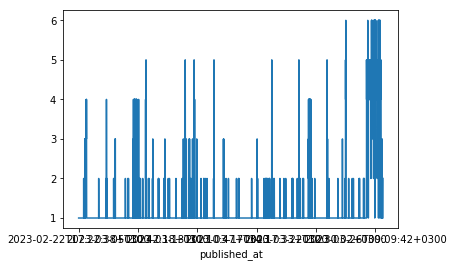

In [200]:
import matplotlib.pyplot as plt

vacancies_by_date = df.groupby('published_at').count()['id']
vacancies_by_date.plot()
plt.show()

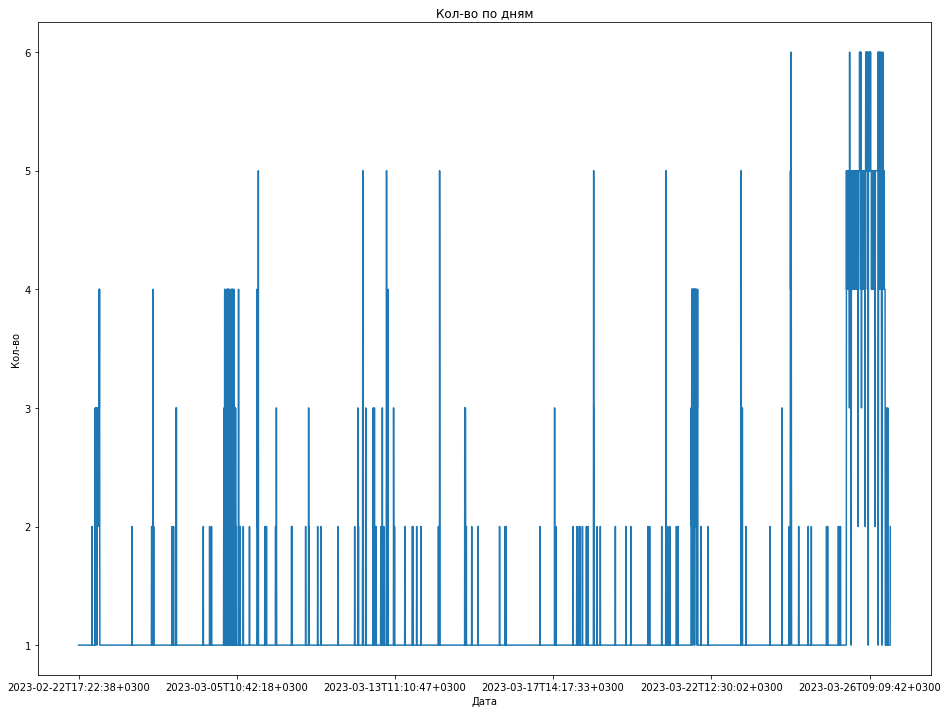

In [199]:
fig, ax = plt.subplots(figsize=(16, 12))
vacancies_by_date.plot(ax=ax)

ax.set_title('Кол-во по дням')
ax.set_xlabel('Дата')
ax.set_ylabel('Кол-во')

plt.show()

In [73]:
#Переведите даты в дни недели, и определите день недели, в который больше всего публикуют вакансий

df['weekday'] = df['published_at'].dt.day_name()

most_common_day = df['weekday'].value_counts().index[0]

print('День публикации вакансии обычно:', most_common_day)

День публикации вакансии обычно: Sunday


In [103]:
print(df.dtypes)

id                                             object
published_at    datetime64[ns, pytz.FixedOffset(180)]
name                                           object
description                                    object
key_skills                                     object
weekday                                        object
dtype: object


In [118]:
df.head(100)

,id,published_at,name,description,key_skills,weekday
0,76757027,2023-03-10 11:03:26+03:00,Клиентский менеджер прямых продаж,<p>Сбер — лучший работодатель России. У нас 14...,[],Friday
1,78145499,2023-03-16 15:22:50+03:00,Старший клиентский менеджер,<p>Сбер — лучший работодатель России. У нас бо...,[],Thursday
2,78345692,2023-03-21 11:18:31+03:00,Операционный менеджер (СберПервый),<p>Сбер — лучший работодатель России. У нас бо...,[],Tuesday
3,78450564,2023-03-23 12:41:41+03:00,Менеджер по работе с клиентами,<p>Сбер — это 14 тысяч подразделений по всей с...,[],Thursday
4,75619357,2023-03-11 14:55:11+03:00,Старший менеджер по обслуживанию,<p>Сбер — лучший работодатель России. У нас бо...,[],Saturday
...,...,...,...,...,...,...
95,67392024,2023-03-18 17:39:59+03:00,Клиентский менеджер прямых продаж,<p>Сбер — лучший работодатель России. У нас 14...,[],Saturday
96,78187925,2023-03-17 14:46:47+03:00,Менеджер по продажам продуктов эквайринга,<p>Сбер — лучший работодатель России. У нас бо...,[],Friday
97,77821288,2023-03-09 11:55:03+03:00,Старший клиентский менеджер,<p>Сбер — лучший работодатель России. У нас бо...,[],Thursday
98,78051520,2023-03-14 16:52:33+03:00,Менеджер по работе с клиентами,<p>Сбер — лучший работодатель России. У нас 14...,[],Tuesday


In [127]:
df['key_skills'] = df['key_skills'].apply(lambda x: tuple(x) if isinstance(x, list) else x)

print(df['key_skills'].dropna().unique())

[()
 ('Грамотность', 'Телефонные переговоры', 'Ведение переговоров', 'Грамотная речь', 'Работа в команде')
 ('Пользователь ПК', 'Грамотная речь', 'Работа в команде', 'Обучение и развитие', 'Развитие продаж', 'Клиентоориентированность')
 ('Деловая переписка', 'Деловое общение', 'Пользователь ПК', 'Деловая коммуникация', 'Работа в команде')
 ('Поиск и привлечение клиентов', 'Развитие продаж', 'Деловое общение', 'Ведение переговоров', 'Деловая переписка')
 ('Работа в команде', 'Клиентоориентированность', 'Грамотная речь', 'Ориентация на результат', 'Консультирование клиентов')
 ('Банковское кассовое обслуживание', 'Ориентация на клиента')
 ('Поиск и привлечение клиентов', 'B2B Продажи', 'Заключение договоров', 'Клиентоориентированность', 'Телефонные переговоры', 'Холодные продажи')
 ('Обучение и развитие', 'Деловая коммуникация', 'Грамотная речь')
 ('Грамотная речь', 'Работа в команде', 'Активные продажи')
 ('Работа в команде', 'Навыки продаж', 'Консультирование клиентов', 'Грамотная речь

In [2]:
import pandas as pd
df = pd.read_excel('vac.xlsx')

In [14]:
#Найдите вакансии с использованием python, которые вам интересны
df2 = df[df['name'].str.contains('Data')]

In [24]:
df3 = df2[df2['key_skills'].str.contains('Python')]
df3.head(10)

,Unnamed: 0,id,published_at,name,description,key_skills
1308,1308,78155339,2023-03-16T19:44:34+0300,Стажер Data Engineer,<p>Блок &quot;Сеть продаж&quot; курирует все ф...,"['Python', 'SQL', 'MS PowerPoint']"
1353,1353,78425859,2023-03-22T21:12:20+0300,Junior Data Scientist,<p> </p> <p><strong>Обязанности:</strong></p> ...,"['Python', 'SQL']"
1401,1401,74267349,2023-02-27T16:28:29+0300,Middle/Senior Data Engineer (SberDevices),<p><strong>SberDevices</strong> - новое направ...,"['Python', 'Big Data', 'SQL']"
1513,1513,69166398,2023-03-23T09:24:27+0300,Аналитик данных / Data Analyst,<p><strong>Аналитик данных / </strong><strong>...,"['Статистический анализ', 'Qlik Sense', 'Матем..."
1552,1552,78387709,2023-03-22T09:31:45+0300,Data Scientist в команду лояльности СберСпасибо,<p>Мы ищем талантливого молодого ML-разработчи...,"['ML-модель', 'Kaggle', 'СберСпасибо', 'МФТИ',..."
1606,1606,78101781,2023-03-15T16:54:05+0300,Data Engineer,"<p>Мы - позитивная и прокаченная команда, кото...","['Hadoop', 'SQL', 'Python', 'PostgreSQL']"
1614,1614,77601746,2023-03-02T14:15:39+0300,Data engineer (Рекламная платформа),"<p>Мы - новая быстрорастущая команда, создающа...","['Git', 'SCALA', 'PostgreSQL', 'Python', 'Hado..."
1648,1648,77601688,2023-03-02T14:14:49+0300,Data Scientist (Рекомендательная система),"<p>Дорогой кандидат, мы - динамично растущая к...","['Python', 'Numpy', 'Pandas', 'Математическая ..."
1730,1730,78043876,2023-03-14T14:59:47+0300,Data Analyst (Предиктивная аналитика),<p>В дивизион Цифровой кредитный мониторинг Ко...,"['Python', 'SQL', 'Анализ данных']"
1750,1750,76654306,2023-03-02T14:26:52+0300,Data Analyst (Anti-fraud),<p>Наша команда занимается противодействием мо...,"['Python', 'SQL', 'Аналитическое мышление', 'Р..."


In [152]:
#Определите по полю с ключевыми навыками, какие навыки больше всего востребованы для найденных вакансий
df4 = df.loc[df['key_skills'] != '[]']
dfx = df4['key_skills'].str.split(',', expand = True)
dfx.columns = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18']
dfy = pd.concat([dfx.loc[:, col] for col in dfx.columns], axis = 0, ignore_index=True)
dfy.columns = ['key_skills_list']

In [163]:
dfy = dfy.str.replace('[','')
dfy = dfy.str.replace(']','')
dfy = dfy.str.replace("'",'')

In [171]:
dfz = pd.DataFrame(dfy)
dfz.columns = ['key_skills_list']

In [194]:
X = dfz.groupby('key_skills_list')['key_skills_list'].count()

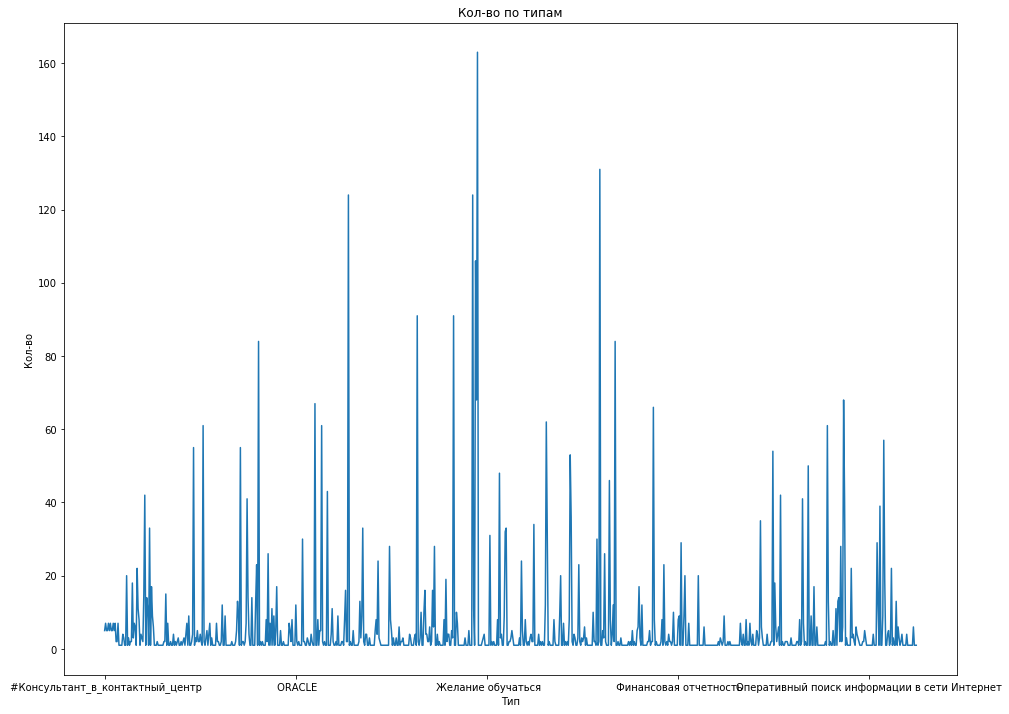

In [204]:
fig, ax = plt.subplots(figsize=(16, 12))
X.plot(ax=ax)

ax.set_title('Кол-во по типам')
ax.set_xlabel('Тип')
ax.set_ylabel('Кол-во')

plt.show()